In [ ]:
from google.colab import drive

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import re
from fastai.vision.all import *
from fastcore.utils import gt

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Talkapalooza - TL BL SS 23

# Scoring the audio predictions:

Despite the model's low accuracy, it has some success recognising recordings of my own voice (which was never used in any of the training or validation datasets). To move ahead and be able to provide a somewhat working API for Talk-a-Palooza's prototype, I want to explore how the results of this model's predictions can be used to score the user's exercises.

In [ ]:
src = '/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5'

In [ ]:
Path(src).ls()

(#345) [Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/big--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/fish--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/there--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/when--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/here--Vivekteraiyavt.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/he--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/not--SpringProof.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/night--Back-ache.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/this--Exilexi.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/some--Opsylac.png')...]

## Creating model from pretrained classes

In [ ]:
words = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)--.+.png$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=240, min_scale=0.85, do_flip = False, max_rotate=0, max_zoom=1.1, max_lighting=0.1, max_warp=0, p_affine=0.9, p_lighting=0.9))
dls = words.dataloaders(src)

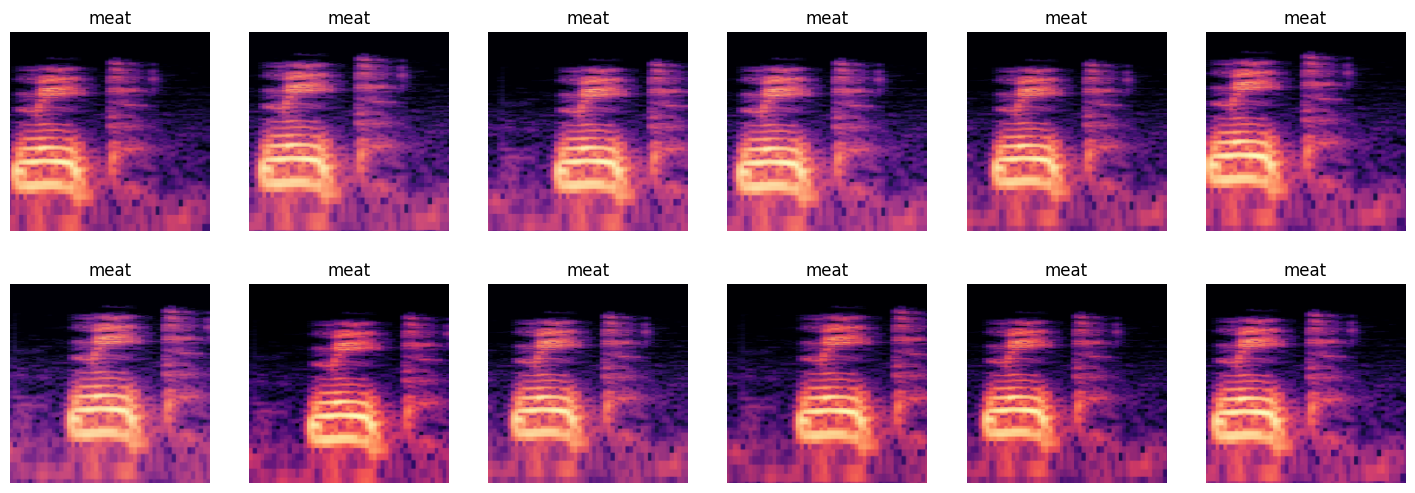

In [ ]:
dls.train.show_batch(max_n=12, nrows=2, unique=True)

### Optimised LR

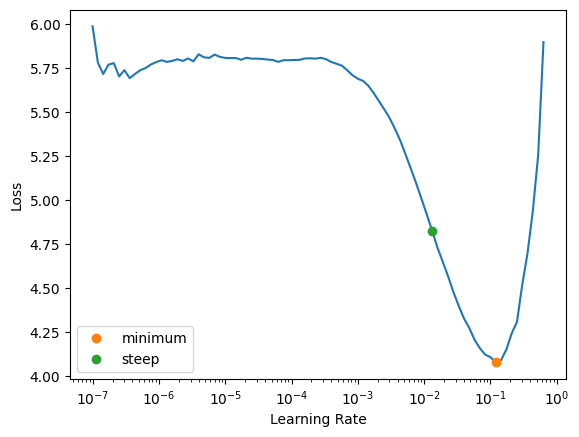

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
lr_min, lr_steep

(0.012022644281387329, 0.013182567432522774)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(20, base_lr=lr_steep)

epoch,train_loss,valid_loss,error_rate,time
0,5.464450,6.809897,0.985507,00:04


epoch,train_loss,valid_loss,error_rate,time
0,4.025498,5.786480,0.985507,00:04
1,3.468470,5.304498,0.956522,00:05
2,2.914363,4.893801,0.927536,00:04
3,2.452430,4.822579,0.913043,00:05
4,2.091998,5.131237,0.811594,00:05
5,1.771871,5.123794,0.768116,00:04
6,1.541361,5.487849,0.782609,00:05
7,1.338966,5.313385,0.753623,00:04
8,1.168965,4.597184,0.797101,00:04
9,1.041523,4.448637,0.782609,00:05


In [ ]:
learn.export()

## Preliminary test predicting test audio using my own voice

In [ ]:
print(f"Night predicts 'night': {learn.predict('./drive/MyDrive/talkapalooza/test_data/night.png')[0] == 'night'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/night.png')[0]}'")
print(f"Fish predicts 'fish': {learn.predict('./drive/MyDrive/talkapalooza/test_data/fish.png')[0] == 'fish'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/fish.png')[0]}'")
print(f"Chicken predicts 'chicken': {learn.predict('./drive/MyDrive/talkapalooza/test_data/chicken.png')[0] == 'chicken'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/chicken.png')[0]}'")
print(f"Tongue predicts 'tongue': {learn.predict('./drive/MyDrive/talkapalooza/test_data/tongue.png')[0] == 'tongue'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/tongue.png')[0]}'")
print(f"Grass predicts 'grass': {learn.predict('./drive/MyDrive/talkapalooza/test_data/grass.png')[0] == 'grass'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/grass.png')[0]}'")
print(f"Flower predicts 'flower': {learn.predict('./drive/MyDrive/talkapalooza/test_data/flower.png')[0] == 'flower'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/flower.png')[0]}'")

Night predicts 'night': True. Predicted: 'night'


Fish predicts 'fish': True. Predicted: 'fish'


Chicken predicts 'chicken': True. Predicted: 'chicken'


Tongue predicts 'tongue': True. Predicted: 'tongue'


Grass predicts 'grass': True. Predicted: 'grass'


Flower predicts 'flower': False. Predicted: 'man'


## Taking a closer look at the learner's predict method

### Case: Successful prediction

#### "Night"

In [ ]:
learn.predict('./drive/MyDrive/talkapalooza/test_data/night.png')

('night',
 tensor(30),
 tensor([1.3144e-07, 1.2386e-04, 3.8702e-06, 4.7722e-05, 5.0610e-06, 1.2466e-06,
         2.5546e-06, 6.8894e-05, 4.1434e-02, 3.7224e-04, 8.3916e-08, 4.4334e-06,
         4.8454e-03, 1.8245e-06, 1.9043e-08, 2.0006e-05, 3.7931e-05, 7.0084e-07,
         9.0922e-07, 2.7682e-04, 2.1625e-07, 6.3694e-06, 1.5281e-06, 8.0644e-07,
         2.2466e-03, 1.1854e-06, 1.1442e-05, 1.4394e-06, 5.9593e-04, 1.4189e-05,
         9.4454e-01, 6.8231e-08, 5.2241e-05, 1.8117e-05, 1.3075e-08, 1.3263e-04,
         5.1241e-07, 2.5348e-07, 7.1045e-06, 2.0533e-06, 4.5566e-03, 1.7945e-09,
         3.0127e-06, 2.0864e-05, 5.1588e-07, 1.4428e-06, 3.5757e-06, 1.3725e-04,
         3.9246e-04, 2.2045e-07, 1.5512e-08, 1.1264e-06, 1.0181e-08]))

In [ ]:
learn.predict('./drive/MyDrive/talkapalooza/test_data/night.png')[1]

tensor(30)

In [ ]:
tensor_arr = learn.predict('./drive/MyDrive/talkapalooza/test_data/night.png')[2]

In [ ]:
np.argmax(tensor_arr)

tensor(30)

In [ ]:
tensor_arr[30]

tensor(0.9445)

In [ ]:
[i for i in range(len(dls.vocab)) if dls.vocab[i] == 'night']

[30]

In [ ]:
dls.vocab[30]

'night'

In [ ]:
ind = np.argpartition(tensor_arr, -5)[-5:]
ind

tensor([24, 40, 12,  8, 30])

In [ ]:
tensor_arr[ind]

tensor([0.0022, 0.0046, 0.0048, 0.0414, 0.9445])

Night has the highest tensor by far.

In [ ]:
tensor_arr[30] - tensor_arr[8]

tensor(0.9031)

### Case: Failed prediction

#### "Flower"

In [ ]:
learn.predict('./drive/MyDrive/talkapalooza/test_data/flower.png')

('child',
 tensor(8),
 tensor([1.7636e-06, 4.2169e-04, 3.0017e-04, 4.1316e-08, 1.9343e-09, 1.3477e-07,
         2.5033e-08, 8.5885e-08, 6.5590e-01, 1.7452e-06, 7.3985e-10, 2.4931e-05,
         3.4651e-07, 1.8528e-07, 2.2704e-08, 3.2837e-01, 9.2064e-09, 1.5381e-05,
         6.6344e-04, 1.2691e-02, 5.0816e-07, 5.0951e-04, 5.9448e-07, 3.3618e-07,
         2.9238e-05, 1.6338e-05, 9.9055e-04, 1.9291e-06, 2.2230e-06, 1.1199e-08,
         2.7717e-05, 4.9546e-08, 6.5364e-09, 2.3767e-05, 3.4465e-06, 2.2044e-08,
         1.0139e-08, 1.0158e-06, 6.9361e-09, 5.5874e-07, 7.7610e-09, 3.9785e-08,
         2.3015e-07, 5.7257e-07, 5.4112e-07, 2.5944e-08, 2.2744e-08, 5.0963e-07,
         3.1665e-07, 8.7891e-08, 3.4416e-06, 2.6503e-07, 3.6361e-08]))

In [ ]:
[i for i in range(len(dls.vocab)) if dls.vocab[i] == 'flower']

[15]

In [ ]:
tensor_arr = learn.predict('./drive/MyDrive/talkapalooza/test_data/flower.png')[2]

In [ ]:
tensor_arr[8]

tensor(0.6559)

In [ ]:
tensor_arr[15]

tensor(0.3284)

In [ ]:
ind = np.array(np.argpartition(tensor_arr, -5)[-5:])
ind

array([18, 26,  8, 19, 15])

In [ ]:
tensor_arr[ind]

tensor([0.0007, 0.0010, 0.6559, 0.0127, 0.3284])

Once again, the correct term matches the second highest tensor value.

In [ ]:
tensor_arr[15] - tensor_arr[8]

tensor(-0.3275)

## Approach to creating a score indicating intelligibility

Two cases:
1. successful prediction
2. unsuccessful prediction

Case 1 should immediately result in a passing score, adjusted for how confident the learner is in the prediction. E.g. if other labels return a similarly high value, it should indicate that it was just barely recognised.

In contrast, an unsuccesful prediction should also look at the gap between the actual word's tensor and the predicted word's tensor. However, this begs the question whether there should ever be a case of a passing score being give in light of the correct prediction being extremely close to the one that was made.

Something to keep in mind however is that the current scoring feature is very much a product of the extremely flawed model. Model improvements demand a redesign of the approach to the scoring function.

### Strict scoring

In [ ]:
def create_intelligibility_score(prediction, target_word):
  is_recognised = False
  score = 0.0

  ind = np.argpartition(prediction[2], -5)[-5:]
  if prediction[1] in ind:
    new_ind = np.delete(ind, [i for i in range(len(ind)) if ind[i] == prediction[1]])
    if prediction[0] == target_word:
      is_recognised = True
      score = prediction[2][prediction[1]] - prediction[2][new_ind][np.argmax(prediction[2][new_ind])]
      if score < 0.5: # for cases where the score would dip below .5, should be handled more elegantly
        score = prediction[2][prediction[1]]
    else:
      score = 0.5 - (prediction[2][prediction[1]] - prediction[2][new_ind][np.argmax(prediction[2][new_ind])])
      if score < 0:
        score = 0
  return is_recognised, score

In [ ]:
night_preds = learn.predict('./drive/MyDrive/talkapalooza/test_data/night.png')
night_preds = learn.predict('./drive/MyDrive/talkapalooza/test_data/night.png')
tongue_preds = learn.predict('./drive/MyDrive/talkapalooza/test_data/tongue.png')
flower_preds = learn.predict('./drive/MyDrive/talkapalooza/test_data/flower.png')
fish_preds = learn.predict('./drive/MyDrive/talkapalooza/test_data/fish.png')
chicken_preds = learn.predict('./drive/MyDrive/talkapalooza/test_data/chicken.png')
grass_preds = learn.predict('./drive/MyDrive/talkapalooza/test_data/grass.png')

In [ ]:
create_intelligibility_score(night_preds, 'night')

(True, tensor(0.6508))

In [ ]:
create_intelligibility_score(tongue_preds, 'tongue')

(True, tensor(0.6594))

In [ ]:
create_intelligibility_score(flower_preds, 'flower')

(False, 0)

In [ ]:
create_intelligibility_score(fish_preds, 'fish')

(True, tensor(0.5293))

In [ ]:
create_intelligibility_score(chicken_preds, 'chicken')

(True, tensor(0.9442))

In [ ]:
create_intelligibility_score(grass_preds, 'grass')

(True, tensor(0.5639))

### Lax scoring

In [ ]:
def create_intelligibility_score_lax(prediction, target_word):
  is_recognised = False
  score = 0.0

  ind = np.argpartition(prediction[2], -5)[-5:]
  if prediction[1] in ind:
    new_ind = np.delete(ind, [i for i in range(len(ind)) if ind[i] == prediction[1]])
    if prediction[0] == target_word:
      is_recognised = True
      score = prediction[2][prediction[1]] - prediction[2][new_ind][np.argmax(prediction[2][new_ind])]
      if score < 0.5: # for cases where the score would dip below .5, should be handled more elegantly
        score = prediction[2][prediction[1]]
    else:
      diff = (prediction[2][prediction[1]] - prediction[2][new_ind][np.argmax(prediction[2][new_ind])])
      if diff < 0.2 and prediction[2][prediction[1]] > 0.4:
        is_recognised = True
        score = prediction[2][prediction[1]]
      else:
        score = 0.5 - diff
      if score < 0:
        score = 0
  return is_recognised, score

In [ ]:
night_preds = learn.predict('./drive/MyDrive/talkapalooza/test_data/night.png')
tongue_preds = learn.predict('./drive/MyDrive/talkapalooza/test_data/tongue.png')
flower_preds = learn.predict('./drive/MyDrive/talkapalooza/test_data/flower.png')
fish_preds = learn.predict('./drive/MyDrive/talkapalooza/test_data/fish.png')
chicken_preds = learn.predict('./drive/MyDrive/talkapalooza/test_data/chicken.png')
grass_preds = learn.predict('./drive/MyDrive/talkapalooza/test_data/grass.png')

In [ ]:
print(create_intelligibility_score_lax(night_preds, 'night'))
print(create_intelligibility_score_lax(tongue_preds, 'tongue'))
print(create_intelligibility_score_lax(flower_preds, 'flower'))
print(create_intelligibility_score_lax(fish_preds, 'fish'))
print(create_intelligibility_score_lax(chicken_preds, 'chicken'))
print(create_intelligibility_score_lax(grass_preds, 'grass'))

(True, tensor(0.6508))
(True, tensor(0.6594))
(False, 0)
(True, tensor(0.5293))
(True, tensor(0.9442))
(True, tensor(0.5639))
